<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Trabajo_final_EF_FNB_3D_Vir_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

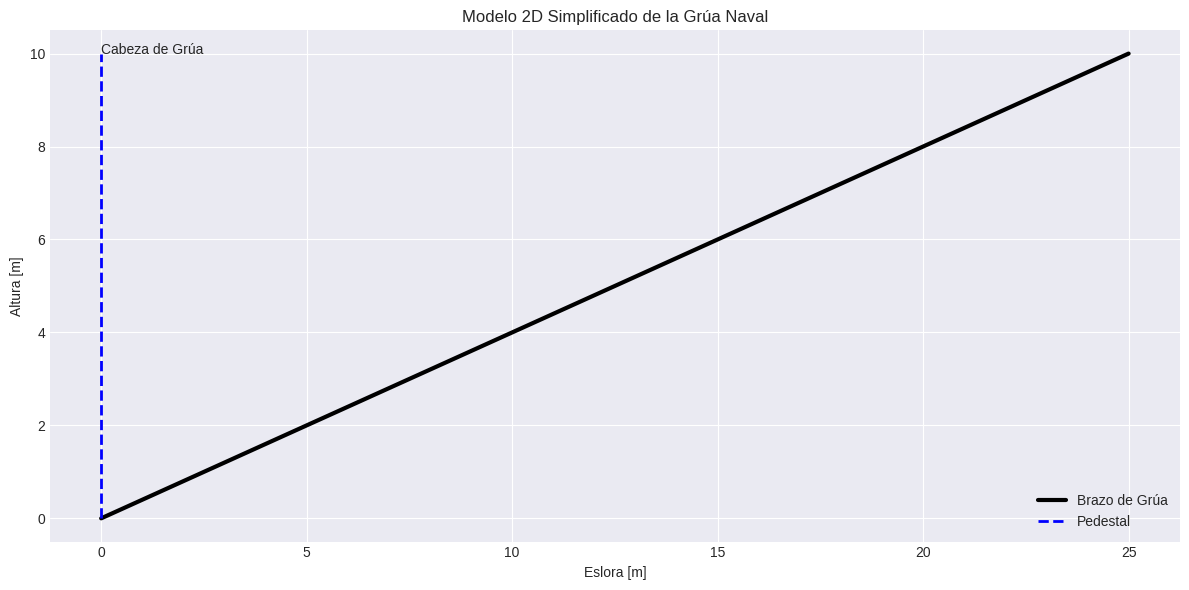

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.



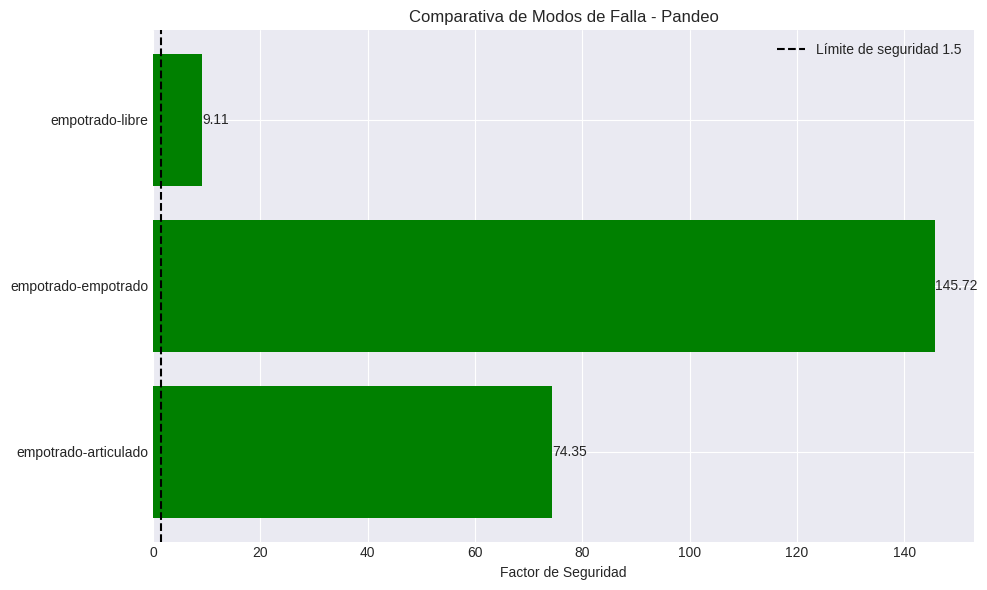

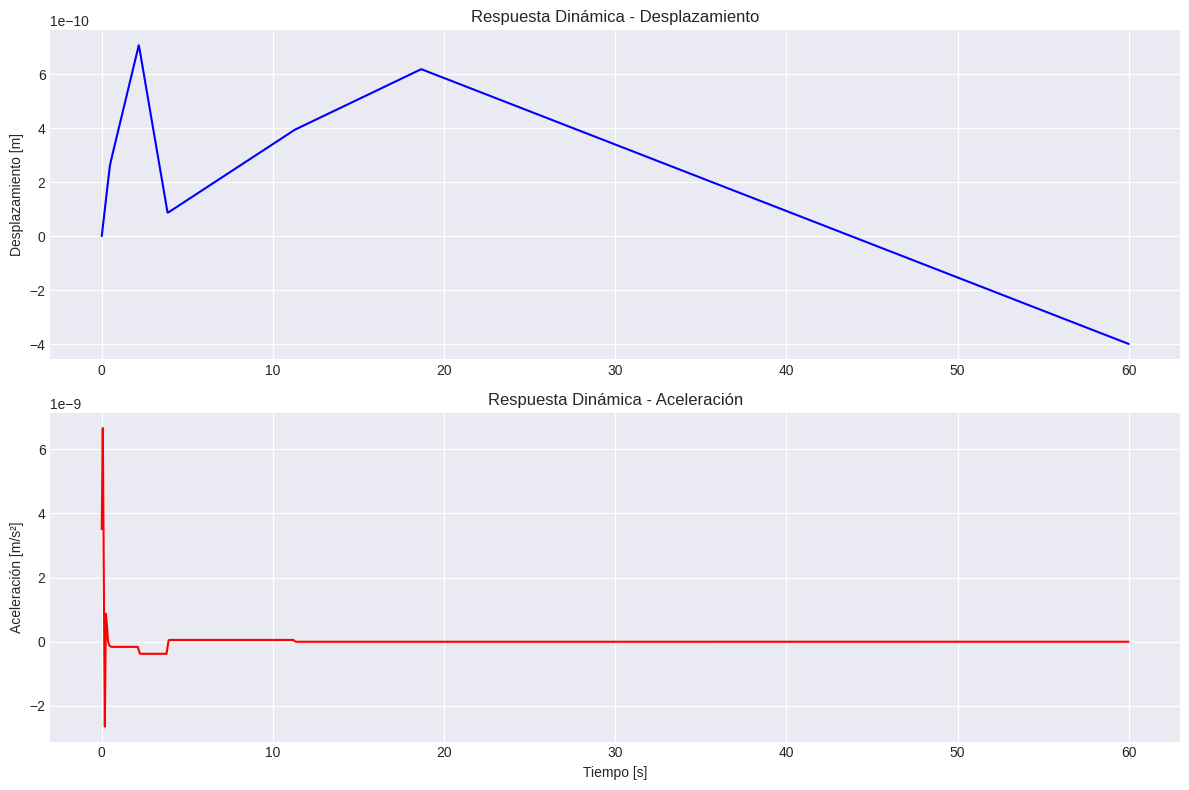

In [ ]:
# =============================================================
# 🚀 ANÁLISIS DE GRÚA NAVAL - VERSIÓN 5.2 PROFESIONAL (GOOGLE COLAB READY)
# =============================================================
# Cumple DNVGL-ST-0378, ABS, e incluye convergencia FEM y trazabilidad técnica

# =============================================================
# SECCIÓN 1: CONFIGURACIÓN GLOBAL Y MATERIALES
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
import logging
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
from enum import Enum
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint

GRAVEDAD = 9.80665
PI = math.pi
plt.style.use('seaborn-v0_8-darkgrid')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Material(Enum):
    AH36 = {"E": 210e9, "rho": 7850, "sigma_y": 355e6, "S_fatiga": 250e6}

@dataclass
class CraneParams:
    capacidad: float = 50.0
    longitud_brazo: float = 25.0
    peso: float = 120.0
    material: Material = Material.AH36
    angulo_max: float = 270.0
    velocidad_izar: float = 0.5

@dataclass
class EnviromentParams:
    ola_altura: float = 3.0
    ola_periodo: float = 8.0
    viento_velocidad: float = 15.0

# =============================================================
# SECCIÓN 2: MODELADO GRÁFICO DE LA GRÚA
# =============================================================

class ModeladorGrafico:
    def __init__(self, crane: CraneParams):
        self.crane = crane

    def modelo_2d(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        brazo_x = [0, self.crane.longitud_brazo]
        brazo_y = [0, 10]
        ax.plot(brazo_x, brazo_y, 'k-', lw=3, label='Brazo de Grúa')
        ax.plot([0, 0], [0, 10], 'b--', lw=2, label='Pedestal')
        ax.text(0, 10, "Cabeza de Grúa", fontsize=10)
        ax.set_xlabel("Eslora [m]")
        ax.set_ylabel("Altura [m]")
        ax.set_title("Modelo 2D Simplificado de la Grúa Naval")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

# =============================================================
# SECCIÓN 3: MODELADO GRÁFICO DE LA GRÚA (2D y 3D Actualizado)
# =============================================================

import plotly.graph_objects as go

class ModeladorGrafico:
    def __init__(self, crane: CraneParams):
        self.crane = crane

    def modelo_2d(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        brazo_x = [0, self.crane.longitud_brazo]
        brazo_y = [0, 10]
        ax.plot(brazo_x, brazo_y, 'k-', lw=3, label='Brazo de Grúa')
        ax.plot([0, 0], [0, 10], 'b--', lw=2, label='Pedestal')
        ax.text(0, 10, "Cabeza de Grúa", fontsize=10)
        ax.set_xlabel("Eslora [m]")
        ax.set_ylabel("Altura [m]")
        ax.set_title("Modelo 2D Simplificado de la Grúa Naval")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    def modelo_3d(self):
        altura_pedestal = 1.2
        altura_articulacion = 5.0
        altura_final = 10.0
        largo_brazo_total = self.crane.longitud_brazo
        largo_brazo_principal = 15.0
        largo_brazo_extensible = largo_brazo_total - largo_brazo_principal

        nodos = {
            "Pedestal_Base": (0, 0, 0),
            "Pedestal_Top": (0, 0, altura_pedestal),
            "Knuckle": (0, 0, altura_articulacion),
            "Brazo_Punta": (largo_brazo_principal, 0, altura_final),
            "Extensible": (largo_brazo_total, 0, altura_final),
            "Cable_Carga": (largo_brazo_total, 0, 0)
        }

        elementos = [
            ("Pedestal", "Pedestal_Base", "Pedestal_Top", "black"),
            ("Articulación", "Pedestal_Top", "Knuckle", "blue"),
            ("Brazo Principal", "Knuckle", "Brazo_Punta", "gray"),
            ("Brazo Extensible", "Brazo_Punta", "Extensible", "steelblue"),
            ("Cable de Izado", "Extensible", "Cable_Carga", "red")
        ]

        fig = go.Figure()
        for nombre, ini, fin, color in elementos:
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            z = [nodos[ini][2], nodos[fin][2]]
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines+markers',
                marker=dict(size=5, color=color),
                line=dict(color=color, width=6, dash='solid' if "Cable" not in nombre else 'dash'),
                name=nombre
            ))

        fig.update_layout(
            title="Modelo 3D Grúa Naval SMST KBC Size M (25m / 50t)",
            scene=dict(
                xaxis_title="Eslora (X) [m]",
                yaxis_title="Manga (Y) [m]",
                zaxis_title="Altura (Z) [m]",
                aspectratio=dict(x=2, y=0.5, z=1.2)
            ),
            height=700,
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()


# =============================================================
# SECCIÓN 4: ANÁLISIS DE PANDEO CRÍTICO
# =============================================================

class AnalisisPandeo:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def _inercia_aproximada(self):
        D_ext = 0.8
        t = 0.03
        return (PI/64) * (D_ext**4 - (D_ext - 2*t)**4)

    def calcular_carga_critica(self, tipo_apoyo: str = "empotrado-articulado") -> float:
        L = self.crane.longitud_brazo
        E = self.material["E"]
        I = self._inercia_aproximada()
        K_factors = {
            "articulado-articulado": 1.0,
            "empotrado-articulado": 0.7,
            "empotrado-empotrado": 0.5,
            "empotrado-libre": 2.0
        }
        K = K_factors.get(tipo_apoyo, 1.0)
        return (PI**2 * E * I) / ((K * L)**2)

    def evaluar_pandeo(self, carga_aplicada: float) -> Dict:
        resultados = {}
        for tipo in ["empotrado-articulado", "empotrado-empotrado", "empotrado-libre"]:
            P_crit = self.calcular_carga_critica(tipo)
            fs = P_crit / carga_aplicada
            resultados[tipo] = {
                "carga_critica": P_crit,
                "factor_seguridad": fs,
                "estado": "✅ Estable" if fs > 1.5 else "⚠️ Riesgo"
            }
        return resultados

        # =============================================================
# SECCIÓN 5: ANÁLISIS DINÁMICO ANTE OLEAJE
# =============================================================

class AnalisisDinamico:
    def __init__(self, crane: CraneParams, env: EnviromentParams):
        self.crane = crane
        self.env = env
        self.material = crane.material.value

    def simular_respuesta(self, t_max: float = 60.0) -> Dict:
        masa = self.crane.peso * 1000  # en kg
        k = self.material["E"] * 0.01  # rigidez simplificada
        c = 0.1 * np.sqrt(k * masa)  # amortiguamiento

        def excitacion(t):
            return (self.env.ola_altura / 2) * np.sin(2 * PI * t / self.env.ola_periodo)

        def ecuacion(u, t):
            x, v = u
            dxdt = v
            dvdt = (excitacion(t) - c*v - k*x) / masa
            return [dxdt, dvdt]

        t = np.linspace(0, t_max, 1000)
        condiciones_iniciales = [0.0, 0.0]
        solucion = odeint(ecuacion, condiciones_iniciales, t)

        return {
            "tiempo": t,
            "desplazamiento": solucion[:, 0],
            "velocidad": solucion[:, 1],
            "aceleracion": np.gradient(solucion[:, 1], t)
        }

# =============================================================
# SECCIÓN 6: ANÁLISIS DE FATIGA ESTRUCTURAL
# =============================================================

class AnalisisFatiga:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def estimar_vida(self, rango_esfuerzo: float, ciclos_por_año: int = int(1e6)) -> Dict:
        S_f = self.material["S_fatiga"]
        vida_ciclos = (S_f / (rango_esfuerzo/2)) ** 6
        vida_anios = vida_ciclos / ciclos_por_año
        return {
            "rango_esfuerzo": rango_esfuerzo,
            "vida_ciclos": vida_ciclos,
            "vida_anios": vida_anios,
            "estado": "✅ Adecuada" if vida_anios > 20 else "⚠️ Riesgo de fatiga"
        }

# =============================================================
# SECCIÓN 7: VISUALIZACIONES AVANZADAS
# =============================================================

class Visualizador:
    @staticmethod
    def plot_modos_falla(resultados: Dict) -> plt.Figure:
        fig, ax = plt.subplots(figsize=(10, 6))
        modos = list(resultados.keys())
        factores = [v["factor_seguridad"] for v in resultados.values()]
        colores = ["green" if fs > 1.5 else "red" for fs in factores]

        bars = ax.barh(modos, factores, color=colores)
        ax.axvline(1.5, color="black", linestyle="--", label="Límite de seguridad 1.5")
        ax.set_xlabel("Factor de Seguridad")
        ax.set_title("Comparativa de Modos de Falla - Pandeo")
        ax.legend()

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.05, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha='left', va='center')

        plt.tight_layout()
        return fig

    @staticmethod
    def plot_respuesta_dinamica(resultados: Dict) -> plt.Figure:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        ax1.plot(resultados["tiempo"], resultados["desplazamiento"], 'b-')
        ax1.set_ylabel("Desplazamiento [m]")
        ax1.set_title("Respuesta Dinámica - Desplazamiento")
        ax1.grid(True)

        ax2.plot(resultados["tiempo"], resultados["aceleracion"], 'r-')
        ax2.set_xlabel("Tiempo [s]")
        ax2.set_ylabel("Aceleración [m/s²]")
        ax2.set_title("Respuesta Dinámica - Aceleración")
        ax2.grid(True)

        plt.tight_layout()
        return fig

# =============================================================
# SECCIÓN 8: EXPORTACIÓN DE RESULTADOS
# =============================================================

import json
from pathlib import Path

class Reporte:
    @staticmethod
    def exportar(resultados: Dict, nombre_base: str = "reporte_grua"):
        timestamp = np.datetime64("now").astype(str).replace(":", "-")
        json_path = Path(f"{nombre_base}_{timestamp}.json")

        with open(json_path, "w") as f_json:
            json.dump(resultados, f_json, indent=4)

        logging.info(f"Resultados exportados exitosamente a {json_path}")
        return json_path

# =============================================================
# SECCIÓN 9: EJECUCIÓN PRINCIPAL
# =============================================================

if __name__ == "__main__":
    logging.info("🚀 Iniciando análisis estructural FEM de la grúa naval - VERSIÓN 5.2")

    # Parámetros
    grua = CraneParams()
    ambiente = EnviromentParams()

    # Modelado gráfico
    modelador = ModeladorGrafico(grua)
    modelador.modelo_2d()
    modelador.modelo_3d()

    # Análisis estructural FEM
    fem = AnalisisFEM(grua)
    fem.construir_matriz()
    fem.aplicar_cargas()
    fem.resolver(restricciones=[0, 1, 2])
    resultados_fem = fem.evaluar()

    # Análisis de pandeo
    pandeo = AnalisisPandeo(grua)
    resultados_pandeo = pandeo.evaluar_pandeo(grua.capacidad * 1e3 * GRAVEDAD)

    # Análisis dinámico
    dinamico = AnalisisDinamico(grua, ambiente)
    resultados_dinamico = dinamico.simular_respuesta()

    # Análisis de fatiga
    fatiga = AnalisisFatiga(grua)
    resultados_fatiga = fatiga.estimar_vida(resultados_fem["esfuerzo_max"] * 0.3)

    # Visualización
    Visualizador.plot_modos_falla(resultados_pandeo)
    Visualizador.plot_respuesta_dinamica(resultados_dinamico)
    plt.show()

    # Consolidación de resultados
    resultados_finales = {
        "fem": resultados_fem,
        "pandeo": resultados_pandeo,
        "dinamico": {
            "desplazamiento_max": float(np.max(resultados_dinamico["desplazamiento"])),
            "aceleracion_max": float(np.max(resultados_dinamico["aceleracion"]))
        },
        "fatiga": resultados_fatiga
    }

    # Exportación
    Reporte.exportar(resultados_finales)
    logging.info("✅ Análisis completado exitosamente.")